# State preparation with the SLM mask

## Basics

When performing quantum computations with global pulses, it might be hard to prepare the system in an arbitrary initial state. This is especially true in the XY mode, where only a global $\sigma^x$ pulse can produce excitations whose number is otherwise conserved during free evolution. A partial solution to this problem is to utilize an SLM mask. <br>
Assume a system of three qubits in XY mode is initially in state $\left| \downarrow \downarrow \downarrow \right\rangle$, and that we are interested in preparing the state $\left| \uparrow \downarrow \downarrow \right\rangle$. Acting naively with a global $\sigma^x$ pulse of area $\pi$ would result in state $\left| \uparrow \uparrow \uparrow \right\rangle$. Using an SLM pattern, however, it is possible to detune the last two qubits away from resonance, and the same global $\sigma^x$ pulse will produced instead the desired state $\left| \uparrow \downarrow \downarrow \right\rangle$. <br>
Let's see how it works in practice. First create the register:

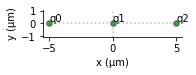

In [1]:
import numpy as np
from pulser import Pulse, Sequence, Register
from pulser.devices import MockDevice
from pulser.waveforms import BlackmanWaveform
from pulser.simulation import Simulation

# Qubit register
qubits = {"q0": (-5,0), "q1": (0,0), "q2": (5,0)}
reg = Register(qubits)
reg.draw()

Now create the sequence and add a global $\sigma^x$ pulse of area $\pi$ in XY mode:

In [2]:
# Create the sequence
seq = Sequence(reg, MockDevice)

# Declare a global XY channel and add the pi pulse
seq.declare_channel('ch', 'mw_global')
pulse = Pulse.ConstantDetuning(BlackmanWaveform(200, np.pi), 0, 0)
seq.add(pulse, 'ch')

Drawing the sequence will show the following:

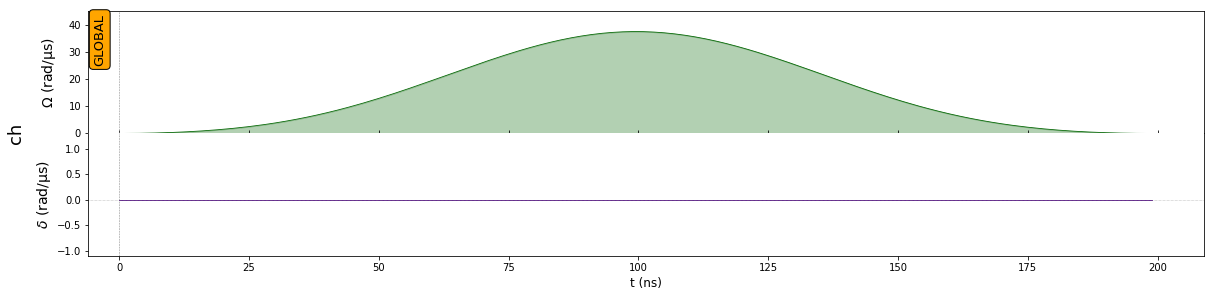

In [3]:
seq.draw()

To set up the SLM mask all we need to do is to create a list that contains the name of the qubits that we want to mask, and pass it to the $\verb:Sequence.config_slm_mask:$ method:

In [4]:
# Mask the last two qubits
masked_qubits = ["q1", "q2"]
seq.config_slm_mask(masked_qubits)

At this point it is possible to visualize the mask by drawing the sequence. The masked pulse will appear with a shaded background, and the names of the masked qubits will be shown in the bottom left corner.

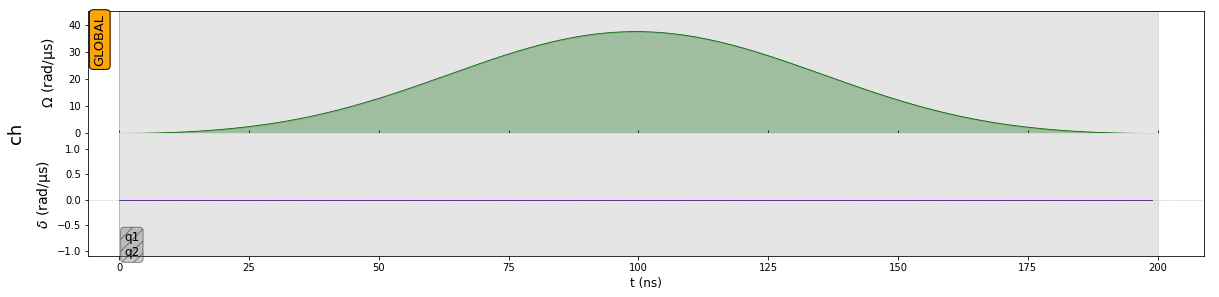

In [5]:
seq.draw()

The sequence drawing method also allows to visualize the register. If an SLM mask is defined, the masked qubits will appear with a shaded square halo around them:

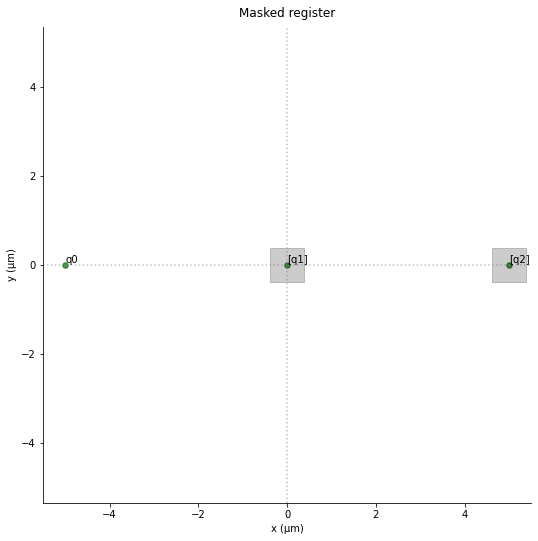

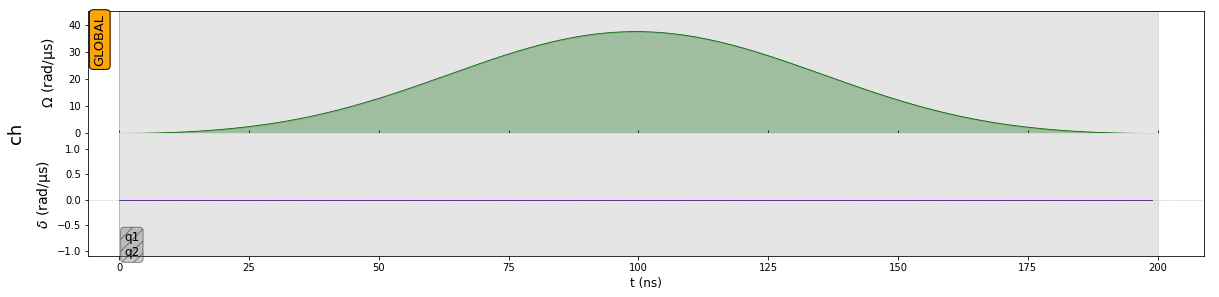

In [6]:
seq.draw(draw_register=True)

Now let's see how the system evolves under this masked pulse. Since the pulse only acts on the first qubit, we expect the final state to be $\left| \uparrow \downarrow \downarrow \right\rangle$, or, according to Pulser's conventions for XY basis states, $(1,0)^T \otimes (0,1)^T \otimes (0,1)^T$ in the Hilbert space $C^8$:

In [7]:
import qutip

qutip.tensor(qutip.basis(2, 0), qutip.basis(2, 1), qutip.basis(2, 1))

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]

Now run the simulation and print the final state as given by Pulser:

In [8]:
sim = Simulation(seq)
results = sim.run()

results.get_final_state()

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.+0.00000000e+00j]
 [0.+0.00000000e+00j]
 [0.+0.00000000e+00j]
 [1.+0.00000000e+00j]
 [0.+0.00000000e+00j]
 [0.+0.00000000e+00j]
 [0.+0.00000000e+00j]
 [0.+1.03821967e-05j]]

As expected, the two states agree up to numerical errors.

## Notes

Since the SLM mask is mostly useful for state preparation, its use in Pulser is restricted to the first pulse in the sequence. This can be seen by adding an extra pulse in the previous example and drawing the sequence:

In [9]:
seq.add(pulse, 'ch')

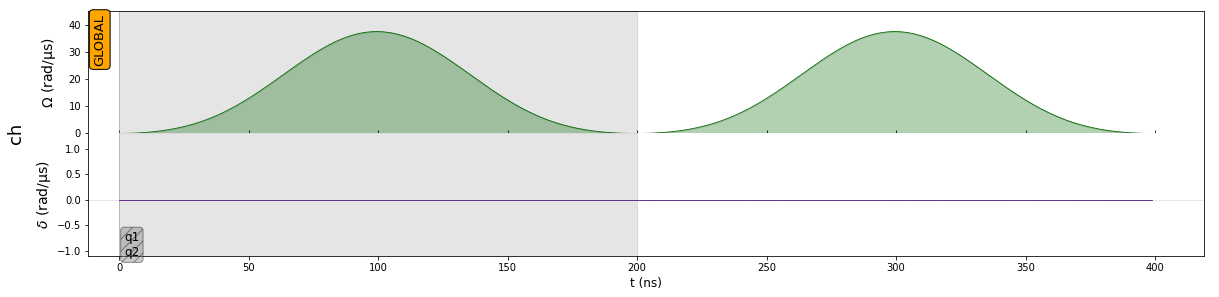

In [10]:
seq.draw()

This example also illustrates the fact that the SLM mask can be configured at any moment during the creation of a sequence (either before or after adding pulses) and it will automatically latch to the first pulse. <br>
However, in order to reflect real hardware constraints, the mask can be configured only once. Trying to configure the mask a second time will raise an error:

In [11]:
try:
    seq.config_slm_mask(masked_qubits)
except ValueError as err:
    print(err)

SLM mask can be configured only once.


Although the example shown here makes use of the XY mode, everything translates directly to the Ising mode as well with the same syntax and restrictions.